#Supervised learning cheat sheet

This notebook contains a comparision of several commonly-used supervised learning algorithms. It should be useful as a quick reference or for people currently studying for machine learning interviews.

To better understand each classifier we train on various version of the "two moons" dataset and plot empirical decision boundaries. These plots show that linear classifiers don't change as drastically as nonlinear classifiers when noise levels and available training data change. This suggests that linear classifiers are often out performed on high quality training sets but will produce sane results on noisy small datasets. **Note: not all the plots have the same xy dimensions**

Other resources:
+ http://blog.echen.me/2011/04/27/choosing-a-machine-learning-classifier/ (about choosing classifier)
+ http://hunch.net/?p=22 (about overfitting)
+ http://www.dataschool.io/comparing-supervised-learning-algorithms/ 
+ https://github.com/soulmachine/machine-learning-cheat-sheet (more like cheat 100 sheets)
+ http://webdocs.cs.ualberta.ca/~greiner/C-466/SLIDES/3b-Regression.pdf
+ http://scott.fortmann-roe.com/docs/BiasVariance.html


In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
%pylab inline

#sklearn sample generator doing lots of this
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Populating the interactive namespace from numpy and matplotlib


In [2]:
"""
Build some datasets that I'll demo the models on
"""
Xs = []
ys = []

#low noise, plenty of samples, should be easy
X0, y0 = sklearn.datasets.make_moons(n_samples=1000, noise=.05)
Xs.append(X0)
ys.append(y0)

#more noise, plenty of samples
X1, y1 = sklearn.datasets.make_moons(n_samples=1000, noise=.3)
Xs.append(X1)
ys.append(y1)

#less noise, few samples
X2, y2 = sklearn.datasets.make_moons(n_samples=200, noise=.05)
Xs.append(X2)
ys.append(y2)

#more noise, less samples, should be hard
X3, y3 = sklearn.datasets.make_moons(n_samples=200, noise=.3)
Xs.append(X3)
ys.append(y3)

In [3]:
def plotter(model, X, y, ax, npts=10000):
    """
    Simple way to get a visualization of the decision boundary 
    by applying the model to randomly-chosen points
    could alternately use sklearn's "decision_function"
    """
    dfX = pd.DataFrame(X,columns=['x0','x1'])
    dfy = pd.DataFrame(y,columns=['y'])
    train_df = pd.concat([dfX,dfy],axis=1)
    xs = []
    ys = []
    cs = []
    for _ in range(npts):
        x0spr = train_df['x0'].max()-train_df['x0'].min()
        x1spr = train_df['x1'].max()-train_df['x1'].min()
        x = np.random.rand()*x0spr + train_df['x0'].min()
        y = np.random.rand()*x1spr + train_df['x1'].min()
        xs.append(x)
        ys.append(y)
        cs.append(model.predict([x,y]))
    ax.scatter(xs,ys,c=cs, alpha=.35)
    ax.hold(True)
    ax.scatter(train_df['x0'],train_df['x1'],
                c=train_df['y'].map(lambda x:'r' if x else 'lime'), 
                linewidth=0,s=25,alpha=1)
    ax.set_xlim([train_df['x0'].min(), train_df['x0'].max()])
    ax.set_ylim([train_df['x1'].min(), train_df['x1'].max()])
    return

##Logistic Regression

Logistic regression is the canoncial example of a "discriminative" classifier (i.e. one that learns the mapping $f:X \rightarrow Y$ directly from the signal as opposed from learning a model of how the data was generated). Here, $Y$ is categorical and $X$ may be either continuous or categorical.

Logistic regression assumes that $f$ is a sigmoid function of an inner product with the features, eg.

$$
P(Y=1 | X;m \theta) = \sigma(\theta ^T X) = \frac{1}{1+exp(\theta ^T X)}
$$

Training a logistic regression classifier amounts to learning the parameters, $\theta$. The most simple approach is via maximum liklihood estimation. This leads to the convex unconstrained optimization:

$$
argmin_\theta = -\sum_{i=1}^M -log(P(Y_i | X_i; \theta)
$$

The MLE approach may suffer from overfitting. It is possible to reduce the effect of overfitting by introducing a user-defined parameter, $\beta$, and introducing a regularization term. To accomplish this one often assumes a Laplacian prior ( $P(\theta) = (\beta/2)^N exp(-\beta/|\theta|_1)$ ) and then does a MAP estimate[5]:

$$
argmin_\theta = -\sum_{i=1}^M -log(P(Y_i | X_i; \theta) + \beta |\theta|_{1 \text{ or } 2}
$$

Regularizing with $L_1$ favors a sparser $\theta$ (i.e. a simpler model) at the expense of a more difficult optimization problem.


###Pros:
+ Liblinear is usually available [1]
+ No user-defined parameters to experiment with unless you regularize (which you do), $\beta$ is intuitive
+ Fast to train (unless $L_1$ regularized)
+ Fast to apply
+ You probably won't get fired for suggesting it
+ No assumptions about P(X|Y) during the learning stage (true of any discriminative method)
+ Logistic Regression is available in Spark [6]
+ Mark Tygert has done some writing about it [7]
+ Robust to outliers when compared against LDA (LDA assumes normal distributions in the density of the training data)


###Cons:
+ Often less accurate than the newer methods
+ Interpreting $\theta$ isn't straightforward
+ $L_1$ optimization is not easy
+ Bizarre use of the word "regression"


###Neutral:
+ Parametric
+ Discriminative
+ Somehow equlivalent to neural networks with a single hidden layer
+ Somehow equlivalent to Gaussian naive Bayes


[1] http://www.csie.ntu.edu.tw/~cjlin/papers/liblinear.pdf

[2] https://www.cs.cmu.edu/~tom/mlbook/NBayesLogReg.pdf

[3] https://cs.stanford.edu/people/ang//papers/nips01-discriminativegenerative.pdf

[4] http://stackoverflow.com/questions/879432/what-is-the-difference-between-a-generative-and-discriminative-algorithm

[5] https://cs.stanford.edu/people/ang//papers/aaai06-efficientL1logisticregression.pdf

[6] https://spark.apache.org/docs/1.1.0/mllib-linear-methods.html

[7] http://www.cims.nyu.edu/~tygert/lr.pdf 

[8] http://math.arizona.edu/~hzhang/math574m/2014Lect6_LDAlog.pdf

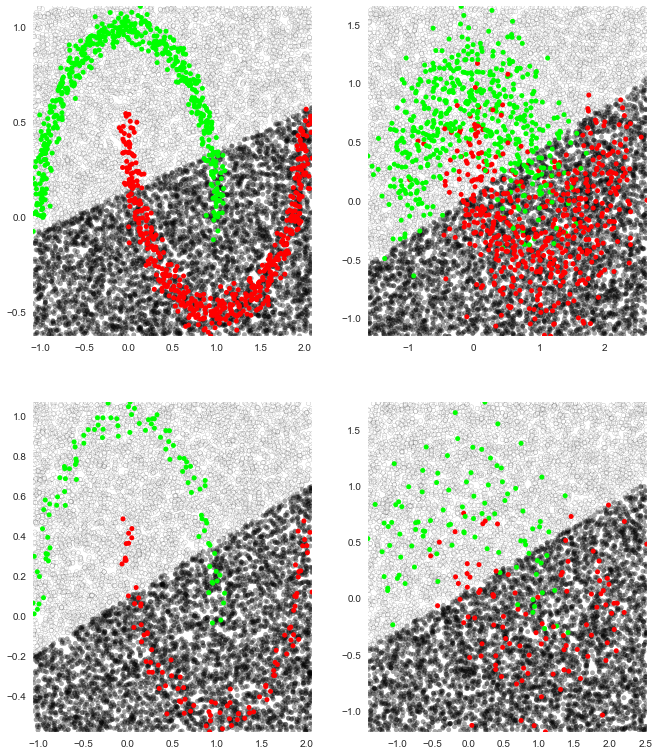

In [4]:
import sklearn.linear_model
classifier = sklearn.linear_model.LogisticRegression()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,13))
i=0
for X,y in zip(Xs,ys): 
    classifier.fit(X,y)
    plotter(classifier,X,y,ax=axes[i//2,i%2])
    i += 1
plt.show()

***

##Decision trees

Decision trees are opposite logistic regression in a few ways. Decision trees are nonlinear, nonparametric, and generate models which are simple to interpret (basically a flowchart). They perform well when given huge amounts of clean data and really shine when the data is not linearly-seperable. Decision trees are often used as an example of a method which is susceptible to overfitting (remark: neural networks are the other example).


####Basic idea to train via a greedy algorithm [6]:

1. Choose the best feature, $a^*$, for the root of the tree.
2. Divided training set, $S$, into subsets $\{S_1, S_2, \ldots ,S_k\}$ where the elements within each subset $S_i$ share the same value for $a^*$. (e.g. divide $[0,1]^2$ into $S_1$, $S_2$ where $S_1$ is points to the left of $x=0.5$ and $S_2$ contains points to the right_
3. Recursively apply this algorithm on each new subset until all examples have the same class label.

The resulting structure is a kd-tree. Applying the classifier to new points amounts to a standard nearest neighbor query.

Tall trees tend to indicate overfitting, pruning can help. Another way to reduce overfitting is to use a "random forest". Random forest means training multiple decision trees and then building a classifier which applies all the trees to a datapoint and takes the mode of the predictions for the result. Two steps in random forest building [2]:

1. Inject randomness at the data level: build a "bagged forest" by training several trees, each one on altered labelings of your training data
2. Inject randomness at the model level: modify the tree learning algorithm such that at each candidate split only a random subset of features are considered in the division. Typlically, for $p$ features, $\sqrt{p}$ features are used in each split (cf wikipedia).

###Pros:
+ Simple to understand and to interpret. Trees can be visualised. [1]
+ Requires little data preparation (e.g. no data normalisation)
+ Able to handle both numerical and categorical data.
+ Uses a white box model. If a given situation is observable in a model, the explanation for the condition is easily explained by boolean logic. By contrast, in a black box model (e.g., in an artificial neural network), results may be more difficult to interpret.
+ Works well when you have lots of data you don't understand. 

###Cons:
+ **Overfitting** (see bottom right plot)
+ Unstable - small variations in the data may lead to large variations in the tree
+ Finding the optimal decision tree (ie the smallest tree that minimizes training error) is NP-hard, so heuristics are always used
+ Unbalanced data leads to biased trees

###Neutral:
+ Decision trees rely on spatial data structures (i.e. kdtrees) which are complicated. However, Hanan's book has been around for a while so you never actually have to implement these things. [7]
+ The example of "low bias / high variance"
+ Difficult (but possible) to scale. Modern (like, 2015 modern) distributed learning tools have decision tree implementations [3] [4] [5].
+ Nonparametric
+ Discriminative


[1] http://scikit-learn.org/stable/modules/tree.html#tree

[2] http://blog.echen.me/2011/03/14/laymans-introduction-to-random-forests/

[3] https://mahout.apache.org/users/classification/partial-implementation.html

[4] https://spark.apache.org/docs/1.2.0/mllib-decision-tree.html

[5] https://static.googleusercontent.com/media/research.google.com/en/us/pubs/archive/36296.pdf

[6] http://web.engr.oregonstate.edu/~xfern/classes/cs534/notes/decision-tree-7-11.pdf

[7] https://www.cs.umd.edu/~hjs/design.html

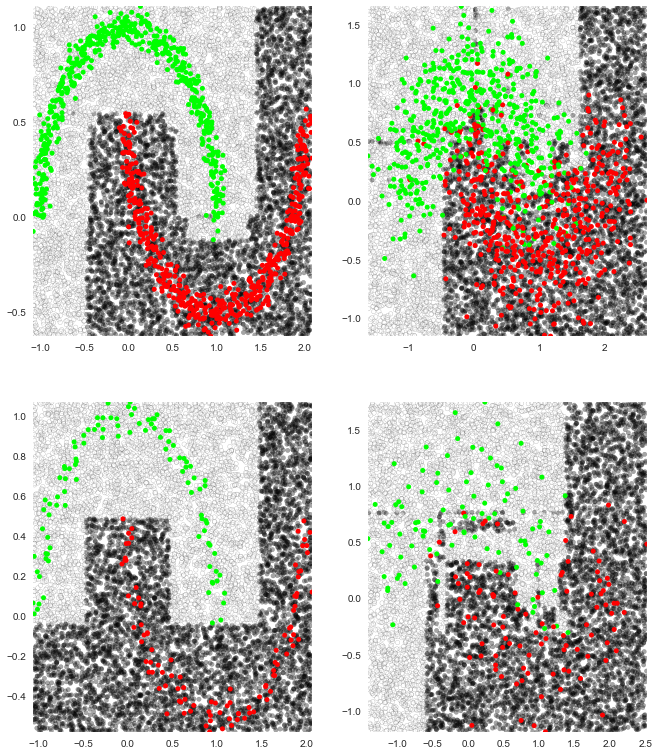

In [5]:
import sklearn.tree
classifier = sklearn.tree.DecisionTreeClassifier()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,13))
i=0
for X,y in zip(Xs,ys): 
    classifier.fit(X,y)
    plotter(classifier,X,y,ax=axes[i//2,i%2])
    i += 1
plt.show()

***

## Support Vector Machines

Support vector machines are non-probabilistic discriminative linear classifiers. They work by finding the hyperplane that has the largest distance to the nearest training-data point of any class between two sets of points. With the commonly-used "kernel trick" (ie mapping all the points to a higher dimensional space (eg a sphere), finding the maximally-separating hyperplane in the high dimension, and then mapping back) they are able to identify nonlinear decision boundaries.

One-class support vector machines are useful to finds outliers or change point detection [3].

Here's the (very) basic idea (the complete derivation is long): There exists a theory bound that says something along the lines of:

#####Test Error $\leq$ Training Error + Complexity of set of Models 

where "Complexity of set of Models" means something about VC dimension [6]. Intuitively, a simple model drags down 2nd term but implies that training error is big, a complex model increases the 2nd term but reduces training error (ie "bounds on overfitting").

So, we want a model that minimizes the sum of the "training error" and the "complexity". Idea: learn a decision function, $f$, to solve

$$
min_f \sum_i label(f(x_i), y_i) + Complexity
$$

Use a separating hyperplane, => $f(x_i) = \theta^T x_i + b$. Use $C||\theta||_{1 or 2}$ as to regularize (ie the "complexity" term). Note: some authors have found that an $L_1$ term makes the method less stable [1].

If linear is not enough, represent all the points in a higher dimensional space (eg expaning to a basis of radial basis functions) and run the optimization in the high dimensional space. 


###Pros:
+ Theoretical bounds on overfitting
+ Effective in high dimensional spaces (ie text).
+ Still effective in cases where number of dimensions is greater than the number of samples.
+ Can use a subset of training points in the decision function (called support vectors), to make it memory efficient.
+ libsvm is usually available
+ <http://www.kernel-machines.org> already exists



###Cons:
+ If the number of features is much greater than the number of samples, the method is likely to give poor performances.
+ SVMs do not directly provide probability estimates, though these can be calculated using an expensive five-fold cross-validation.
+ Selecting the wrong kernel may lead to bad results (ie really hard to tune)
+ Memory intensive unless you do something smart
+ Hard to interpret the model
+ To avoid overfitting you really need to tune the regularization parameter

###Neutral:
+ They really look nice on the two moons dataset
+ Distributed implementations exist [4]
+ Support Vector Machine algorithms are not scale invariant, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X to [0,1] or [-1,+1], or standardize it to have mean 0 and variance 1. Note that the same scaling must be applied to the test vector to obtain meaningful results. [2] [5]





[1] http://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf

[2] http://scikit-learn.org/stable/modules/svm.html

[3] https://rvlasveld.github.io/blog/2013/07/12/introduction-to-one-class-support-vector-machines/

[4] https://spark.apache.org/docs/latest/mllib-guide.html

[5] http://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf

[6] http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf

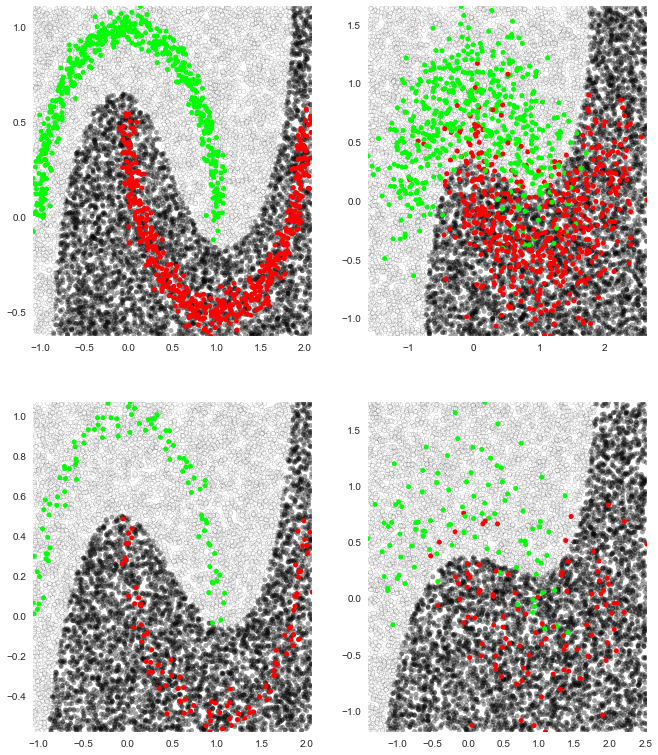

In [6]:
import sklearn.svm
classifier = sklearn.svm.SVC()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,13))
i=0
for X,y in zip(Xs,ys): 
    classifier.fit(X,y)
    plotter(classifier,X,y,ax=axes[i//2,i%2])
    i += 1
plt.show()

##Nearest Neighbors

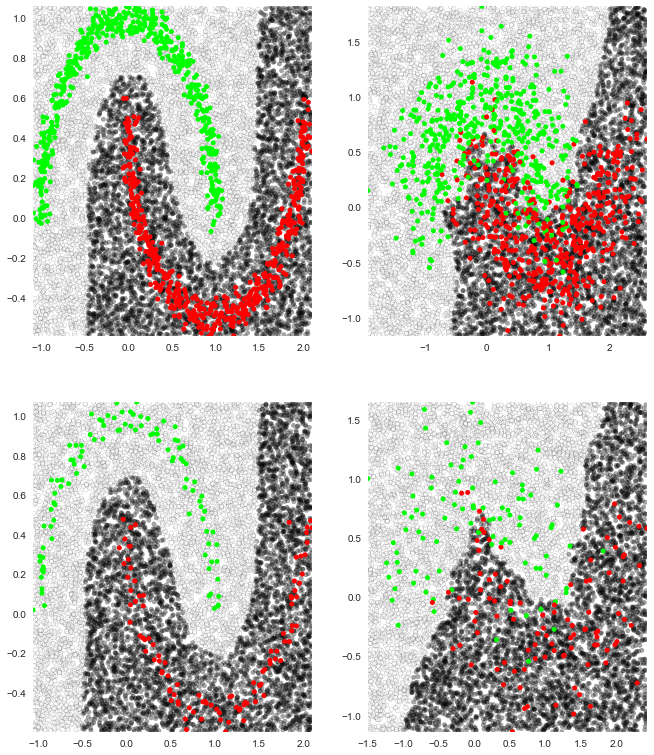

In [156]:
import sklearn.neighbors
classifier = sklearn.neighbors.KNeighborsClassifier()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,13))
i=0
for X,y in zip(Xs,ys): 
    classifier.fit(X,y)
    plotter(classifier,X,y,ax=axes[i//2,i%2])
    i += 1
plt.show()

## Naive Bayes

Gaussian Naive Bayes reduces to Logistic Regression with an l2 regularization. 

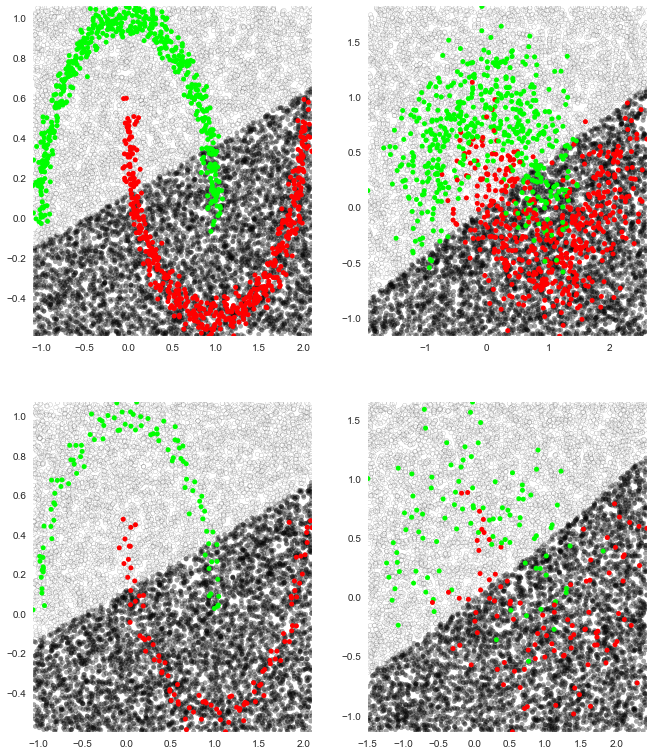

In [160]:
import sklearn.naive_bayes
classifier = sklearn.naive_bayes.GaussianNB()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,13))
i=0
for X,y in zip(Xs,ys): 
    classifier.fit(X,y)
    plotter(classifier,X,y,ax=axes[i//2,i%2])
    i += 1
plt.show()

/home/aahu/.local/lib/python3.4/site-packages/sklearn/datasets/samples_generator.py:612: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = np.hstack([np.zeros(n_samples_in, dtype=np.intp),


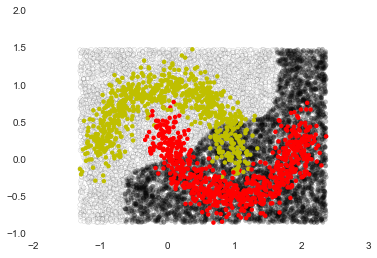

In [3]:
import sklearn.lda

import sklearn.datasets
X, y = sklearn.datasets.make_moons(n_samples=1500, noise=.15, random_state=None)


#curvy
#classifier = sklearn.svm.SVC()

#looks overfit
#classifier = sklearn.tree.DecisionTreeClassifier()

#lda is linear, straigt line
#classifier = sklearn.lda.LDA(n_components=2)

#bayes - straight
#classifier = sklearn.naive_bayes.GaussianNB()

#k nearest neigh
classifier = sklearn.neighbors.RadiusNeighborsClassifier()

classifier.fit(X,y)

dfX = pd.DataFrame(X,columns=['x0','x1'])
dfy = pd.DataFrame(y,columns=['y'])
df = pd.concat([dfX,dfy],axis=1)
plotter(classifier,df,npts=10000)
